## Оглавление
-    Дано<br>
- 0. Ипорт библиотек<br>
- 1. Загрузка данных<br>
- 2. Общая информация<br>
- 3. Дубликаты<br>
- 4. Пропуски<br>
    - 4.1. Соотношение пропусков к общему числу заявок<br>
- 5. Просрочки<br>
    - 5.1. Соотношение просрочек к общему числу платежей<br>
    - 5.2. Сводные показатели по просрочкам<br>
    - 5.3. Распределение просрочек по дням<br>
    - 5.4. Распределение просрочек по суммам<br>
    - 5.5. План-факт по просрочкам<br>
    - 5.6. Отклонения платежей при просрочках<br>
- 6. Динамика поведения клиентов<br>
    - 6.1. Распределение просрочек относительно заявок <br>
    - 6.2. Частота просрочек относительно заявок<br>
- 7. Условная вероятность просрочки<br>
- 8. Вывод

# Дано

`Проанализируйте характер поведения клиентов с точки зрения просрочки: какая динамика просрочки, наблюдается ли рост или снижение?`

**orders** <br>
`order_id` – номер заявки <br>
`created_at` - дата создания заявки  <br>
`put_at` - дата выдачи <br>
`closed_at` - дата закрытия <br>
`issued_sum` - сумма выдачи <br><br>
**payments** <br>
`order_id` – номер заявки <br>
`paid_at` - дата фактического платежа <br>
`paid_sum` - сумма фактического платежа <br><br>
**plan** <br>
`order_id` – номер заявки <br>
`plan_at` – дата планового платежа <br>
`plan_sum_total` - сумма планового платежа (накопленным итогом) <br>

---

# 0. Ипорт библиотек

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import norm

import warnings 
warnings.filterwarnings('ignore')

---

# 1. Загрузка данных

>Так как мы уже знаем какие признаки должны быть с типом данных даты, сразу обработаем их с помощью `parse_dates`

In [10]:
orders = pd.read_csv('task_2_data/orders.csv', parse_dates=['created_at', 'put_at', 'closed_at'])
payments = pd.read_csv('task_2_data/payments.csv', parse_dates=['paid_at'])
plan = pd.read_csv('task_2_data/plan.csv', parse_dates=['plan_at'])

---

# 2. Общая информация

>Таблица orders

In [14]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_id    55748 non-null  int64         
 1   created_at  55748 non-null  datetime64[ns]
 2   put_at      55748 non-null  datetime64[ns]
 3   closed_at   46472 non-null  datetime64[ns]
 4   issued_sum  55748 non-null  float64       
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 2.1 MB


,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0


>У нас 55 748 заявок, так же есть пропуски в признаке closed_at - на заметку для дальнейшего анализа. Типы данных заданы правильно, так что преобразовывать их не потребуется

>Таблица payments

In [17]:
payments.info()
payments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143284 entries, 0 to 143283
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   order_id  143284 non-null  int64         
 1   paid_at   143284 non-null  datetime64[ns]
 2   paid_sum  143284 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.3 MB


,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,2500.0
1,400018480,2022-06-02 01:52:05.707,1070.0
2,400032001,2022-06-02 04:55:40.307,4200.0
3,400033195,2022-06-02 05:44:23.480,2850.0
4,400039407,2022-06-02 06:53:54.503,10100.0


>Имеем 143 284 записи о платежах, пропусков не видно, типы данных корректны

>Таблица plan

In [20]:
plan.info() 
plan.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420282 entries, 0 to 420281
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   order_id        420282 non-null  int64         
 1   plan_at         420282 non-null  datetime64[ns]
 2   plan_sum_total  420282 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 9.6 MB


,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.0
1,400001732,2022-07-02,9450.0
2,400001732,2022-08-01,12170.0
3,400001732,2022-08-31,14890.0
4,400001732,2022-09-30,17610.0


>В таблице 420 282 записей с плановыми платежами, пропусков нету, все типы данных правильны

---

# 3. Дубликаты

> Перед анализом и\или обработкой пропусков посмотрим на дубликаты, которые могут испортить последующий анализ в принципе

In [25]:
print(f'Кол-во дубликатов таблицы orders: {orders.duplicated().sum()}') 
print(f'Кол-во дубликатов таблицы payments: {payments.duplicated().sum()}')
print(f'Кол-во дубликатов таблицы plan: {plan.duplicated().sum()}')

Кол-во дубликатов таблицы orders: 0
Кол-во дубликатов таблицы payments: 5
Кол-во дубликатов таблицы plan: 0


>Теперь сложно не заметить дубликаты и хоть их невероятно мало относительно всех данных, мы все равно рассмотрим их <br><br>
>Для начала посмотрим на все платежи заявок, которые дублируются

In [27]:
duble = np.array(payments[payments.duplicated()]['order_id'])

for order_id in duble:
    print(f'\t\torder_id: {order_id}\n{payments[payments['order_id'] == order_id]}\n')

		order_id: 411504997
        order_id                 paid_at  paid_sum
11474  411504997 2022-06-24 17:14:56.997   10100.0
11475  411504997 2022-06-24 17:14:56.997   10100.0

		order_id: 422632789
        order_id             paid_at  paid_sum
12469  422632789 2022-06-25 23:16:16    8080.0
12470  422632789 2022-06-25 23:16:16    8080.0

		order_id: 432761640
        order_id                 paid_at  paid_sum
18532  432761640 2022-07-03 15:09:34.300     720.0
37758  432761640 2022-07-21 12:38:12.000     150.0
37759  432761640 2022-07-21 12:38:12.000     150.0

		order_id: 420036980
         order_id                 paid_at  paid_sum
8918    420036980 2022-06-21 12:37:01.740    6900.0
38413   420036980 2022-07-21 20:08:58.997    4800.0
38414   420036980 2022-07-21 20:08:58.997    4800.0
111597  420036980 2022-09-20 22:13:37.997    1962.0

		order_id: 456075017
         order_id                 paid_at  paid_sum
42479   456075017 2022-07-25 19:14:20.427    5600.0
80905   456075017 2022-0

>Тепреь можно наблюдать эти дубликаты и убедиться, что они действительны, так что избавимся от них

In [29]:
payments = payments.drop_duplicates()

for order_id in duble:
    print(f'\t\torder_id: {order_id}\n{payments[payments['order_id'] == order_id]}\n')

		order_id: 411504997
        order_id                 paid_at  paid_sum
11474  411504997 2022-06-24 17:14:56.997   10100.0

		order_id: 422632789
        order_id             paid_at  paid_sum
12469  422632789 2022-06-25 23:16:16    8080.0

		order_id: 432761640
        order_id                 paid_at  paid_sum
18532  432761640 2022-07-03 15:09:34.300     720.0
37758  432761640 2022-07-21 12:38:12.000     150.0

		order_id: 420036980
         order_id                 paid_at  paid_sum
8918    420036980 2022-06-21 12:37:01.740    6900.0
38413   420036980 2022-07-21 20:08:58.997    4800.0
111597  420036980 2022-09-20 22:13:37.997    1962.0

		order_id: 456075017
         order_id                 paid_at  paid_sum
42479   456075017 2022-07-25 19:14:20.427    5600.0
80905   456075017 2022-08-24 08:24:27.033    3850.0
111943  456075017 2022-09-21 13:09:09.867    2720.0
129364  456075017 2022-10-22 10:05:08.290    2720.0
139589  456075017 2022-11-22 19:44:08.793    2720.0



In [30]:
print(f'Кол-во дубликатов таблицы payments: {payments.duplicated().sum()}')

Кол-во дубликатов таблицы payments: 0


> Теперь в наших таблицах нет повторений

---

# 4. Пропуски

>После того как мы избавились от повторений, можно посмотреть и на пропуски<br><br>
>Еще раз на всякий случай посмотрим на наличие пропусков во всех таблицах  

In [35]:
print(f'пропущенные значения в таблице: {sum(orders.isnull().sum())}')
print(f'пропущенные значения в таблице: {sum(payments.isnull().sum())}')
print(f'пропущенные значения в таблице: {sum(plan.isnull().sum())}')

пропущенные значения в таблице: 9276
пропущенные значения в таблице: 0
пропущенные значения в таблице: 0


In [36]:
print(f'пропущенные значения по признакам в таблице orders: \n{orders.isnull().sum()}')

пропущенные значения по признакам в таблице orders: 
order_id         0
created_at       0
put_at           0
closed_at     9276
issued_sum       0
dtype: int64


>В таблице orders не было дубликатов, но, в отличии от других таблиц, есть пропуски и если рассматривать пропуски признака `closed_at` в контексте, то не сложно догадаться, что пустые значения - это заявки, которые не закрыты

---

## 4.1. Cоотношение пропусков к общему числу заявок

> Рассмтрим соотношение пропусков  к общему числу заявок и чтобы не путаться отделим заявки с пропусками 

In [41]:
non_closed_orders = orders[orders['closed_at'].isnull()]
non_closed_orders.head()

,order_id,created_at,put_at,closed_at,issued_sum
31,400039450,2022-06-02 06:06:20.000,2022-06-02 17:04:46.147,NaT,8140.0
53,400087077,2022-06-02 06:49:06.997,2022-06-02 06:50:21.053,NaT,2920.0
62,400104071,2022-06-02 07:24:24.000,2022-06-02 07:40:44.230,NaT,1720.0
67,400114009,2022-06-02 07:46:38.000,2022-06-02 07:54:54.360,NaT,13600.0
80,400128637,2022-06-02 08:37:15.000,2022-06-02 08:56:56.887,NaT,8500.0


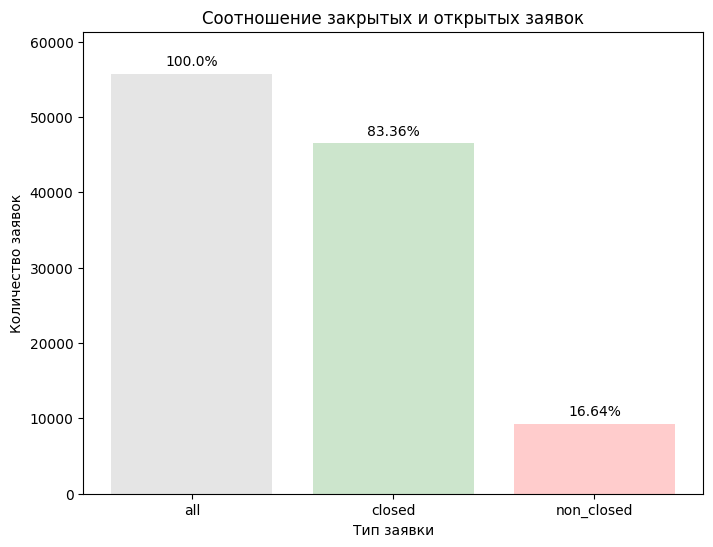

In [42]:
# метки и значения
labels = ['all', 'closed', 'non_closed']
vals = [len(orders), len(orders)-len(non_closed_orders), len(non_closed_orders)]

# вычисляем соотношение
percents = [v / len(orders) * 100 for v in vals]

plt.figure(figsize = (8, 6))
bars = plt.bar(labels, vals, color = ['grey', 'green', 'red'], alpha=0.2)

# рисуем поценты над столбиками
for bar, percent in zip(bars, percents):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, 
             height + len(orders) * 0.02,
             f'{round(percent, 2)}%', 
             ha='center', 
             fontsize = 10)
    
plt.ylim(0, max(vals) * 1.1)  
plt.title('Соотношение закрытых и открытых заявок')
plt.xlabel('Тип заявки')
plt.ylabel('Количество заявок')
plt.show()

>Видим, что наши 9 276 не закрытых заявок закрывают 16.64 процента  всех заявок

---

# 5. Просрочки

>Чтобы было удобно работать с просроченными платежами соеденим таблицы `plan` и `payments`, чтобы видеть, когда была плановая и фактическая дата и сумма оплаты

In [47]:
plan_pay = plan.merge(payments, on = 'order_id', how = 'left')
plan_pay.head()

,order_id,plan_at,plan_sum_total,paid_at,paid_sum
0,400001732,2022-06-02,5600.0,2022-06-02 20:20:16.790,5600.0
1,400001732,2022-06-02,5600.0,2022-06-16 16:05:26.007,3850.0
2,400001732,2022-06-02,5600.0,2022-07-15 12:32:34.087,2720.0
3,400001732,2022-06-02,5600.0,2022-08-16 12:38:01.237,2720.0
4,400001732,2022-06-02,5600.0,2022-09-15 12:14:48.867,2720.0


>Теперь у нас есть таблица, но для анализа просрочек нам понадобятся еще некоторые признаки, а именно:<br><br>
>`delay_days` - разница в днях между фактической датой платежа и плановой датой (plan_at) <br>
>`delay_amount` - разница в суммах между фактическим платежом (paid_sum) и плановой суммой <br>
>`is_delay` - флаг, показывающий, был ли платеж задержан <br><br>

In [49]:
plan_pay['delay_days'] = (plan_pay['paid_at'] - plan_pay['plan_at']).dt.days
plan_pay['delay_amount'] = plan_pay['paid_sum'] - plan_pay['plan_sum_total']
plan_pay['is_delay'] = plan_pay['delay_days'] > 0

plan_pay.head()

,order_id,plan_at,plan_sum_total,paid_at,paid_sum,delay_days,delay_amount,is_delay
0,400001732,2022-06-02,5600.0,2022-06-02 20:20:16.790,5600.0,0.0,0.0,False
1,400001732,2022-06-02,5600.0,2022-06-16 16:05:26.007,3850.0,14.0,-1750.0,True
2,400001732,2022-06-02,5600.0,2022-07-15 12:32:34.087,2720.0,43.0,-2880.0,True
3,400001732,2022-06-02,5600.0,2022-08-16 12:38:01.237,2720.0,75.0,-2880.0,True
4,400001732,2022-06-02,5600.0,2022-09-15 12:14:48.867,2720.0,105.0,-2880.0,True


---

## 5.1. Соотношение просрочек к общему числу платежей

>Достаточно важным признаком для нас является `is_delay` (задержки), поэтому рассмотрим его соотношение

In [53]:
plan_pay['is_delay'].value_counts()

is_delay
False    1163444
True      320121
Name: count, dtype: int64

> Для полноты картины мы посмотрели на распределение категрий и увидели, что 1 163 444 не задерженных платежей и 320 121 задерженных

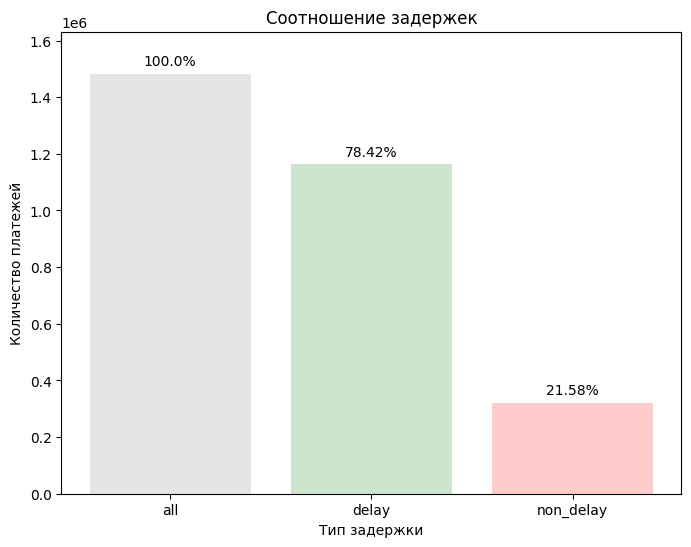

In [55]:
# метки и значения
labels = ['all', 'delay', 'non_delay']
vals = [len(plan_pay['is_delay']), plan_pay['is_delay'].value_counts().iloc[0], plan_pay['is_delay'].value_counts().iloc[1]]

# вычилсяем проценты
percents = [v / len(plan_pay['is_delay']) * 100 for v in vals]

plt.figure(figsize = (8, 6))
bars = plt.bar(labels, vals, color = ['grey', 'green', 'red'], alpha=0.2)

# рисуем проценты над столбиками
for bar, percent in zip(bars, percents):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, 
             height + len(plan_pay['is_delay']) * 0.02,
             f'{round(percent, 2)}%', 
             ha='center', 
             fontsize = 10)
    
plt.ylim(0, max(vals) * 1.1)  
plt.title('Соотношение задержек')
plt.xlabel('Тип задержки')
plt.ylabel('Количество платежей')
plt.show()

>Теперь наглядно понятно сколько платежей было произведено с задержкей, а именно - 21.58% от всех платежей 

---

## 5.2. Сводные показатели по просрочкам

>Немного статистической информации. Не забываем учесть платежи, только с просрочкой

In [60]:
delayed = plan_pay[plan_pay['is_delay'] == True]

print(f"Среднее количество дней задержки: {round(delayed['delay_days'].mean(), 2)}")
print(f"Медианное количество дней задержки: {round(delayed['delay_days'].median(), 2)}\n")

print(f"Средняя сумма задержки: {round(delayed['delay_amount'].mean(), 2)}")
print(f"Медианная сумма задержки: {round(delayed['delay_amount'].median(), 2)}")

Среднее количество дней задержки: 39.43
Медианное количество дней задержки: 30.0

Средняя сумма задержки: -2420.93
Медианная сумма задержки: -2100.0


>Тут все просто и понятно, а именно - в среднем, клиенты, которые платят с опозданием, делают это через `39 дней` после плановой даты. У половины >просроченных платежей задержка не превышает `30 дней` (типичная просрочка — около месяца)<br><br>
>В среднем, клиенты, которые просрочили платеж еще ко всему прочему платят меньше, чем должны - примерно на `2400 руб`. У половины задержек сумма недоплаты составляет `2100 руб`<br><br>
>Посмотрим на такие экземпляры

In [62]:
# значения задержек по дням
negative_delay_days = plan_pay[plan_pay['delay_days'] > 0]

print(f'Кол-во заявок, когда не было задержек по дням: {len(negative_delay_days)}')
print(f'Кол-во заявок в целом: {len(plan_pay)}')

negative_delay_days[['order_id', 'plan_at', 'paid_at', 'delay_days']].head()

Кол-во заявок, когда не было задержек по дням: 320121
Кол-во заявок в целом: 1483565


,order_id,plan_at,paid_at,delay_days
1,400001732,2022-06-02,2022-06-16 16:05:26.007,14.0
2,400001732,2022-06-02,2022-07-15 12:32:34.087,43.0
3,400001732,2022-06-02,2022-08-16 12:38:01.237,75.0
4,400001732,2022-06-02,2022-09-15 12:14:48.867,105.0
5,400001732,2022-06-02,2022-09-27 16:04:50.630,117.0


In [63]:
# проверим отирцательные значения задержек по суммам
excessive_amount = plan_pay[plan_pay['delay_amount'] < 0]

print(f'Кол-во заявок, когда сумма платежа меньше плановой: {len(excessive_amount)}')
print(f'Кол-во заявок целом: {len(plan_pay)}')

excessive_amount[['order_id', 'plan_sum_total', 'paid_sum', 'delay_amount']].head()

Кол-во заявок, когда сумма платежа меньше плановой: 1260511
Кол-во заявок целом: 1483565


,order_id,plan_sum_total,paid_sum,delay_amount
1,400001732,5600.0,3850.0,-1750.0
2,400001732,5600.0,2720.0,-2880.0
3,400001732,5600.0,2720.0,-2880.0
4,400001732,5600.0,2720.0,-2880.0
5,400001732,5600.0,2720.0,-2880.0


---

## 5.3. Распределение просрочек по дням

>Мы знаем некоторые сводные показатели по просрочкам, давайте рассмотрим их по подробнее, а именно - разделим на группы по кол-ву дней и посомтрим на распредление

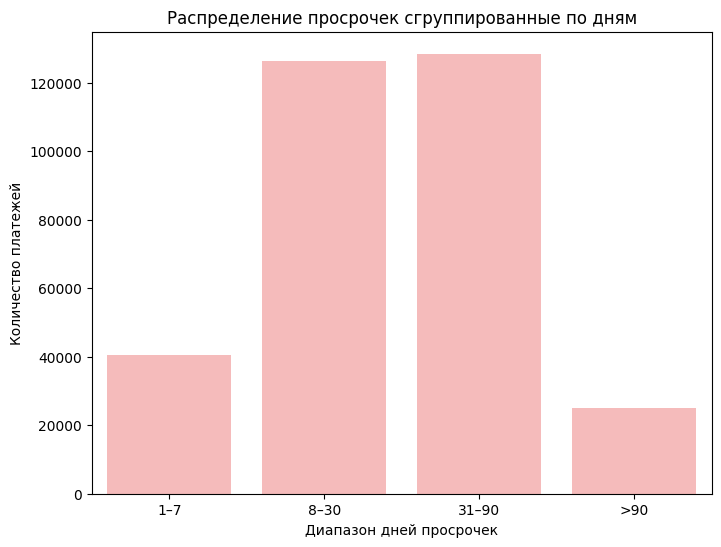

In [67]:
def delay_group(d):
    if d <= 7:
        return '1–7'
    elif d <= 30:
        return '8–30'
    elif d <= 90:
        return '31–90'
    else:
        return '>90'

delayed['delay_group'] = delayed['delay_days'].apply(delay_group)

plt.figure(figsize=(8, 6))
sns.countplot(data=delayed, 
              x='delay_group', 
              order=['1–7', '8–30', '31–90', '>90'], 
              color = 'red', 
              alpha = 0.3)

plt.title('Распределение просрочек сгруппированные по дням')
plt.xlabel('Диапазон дней просрочек')
plt.ylabel('Количество платежей')
plt.show()

>Теперь более наглядно видно на сколько дней идут просрочки

---

## 5.4. Распределение просрочек по суммам

>Теперь построим распределение по суммам

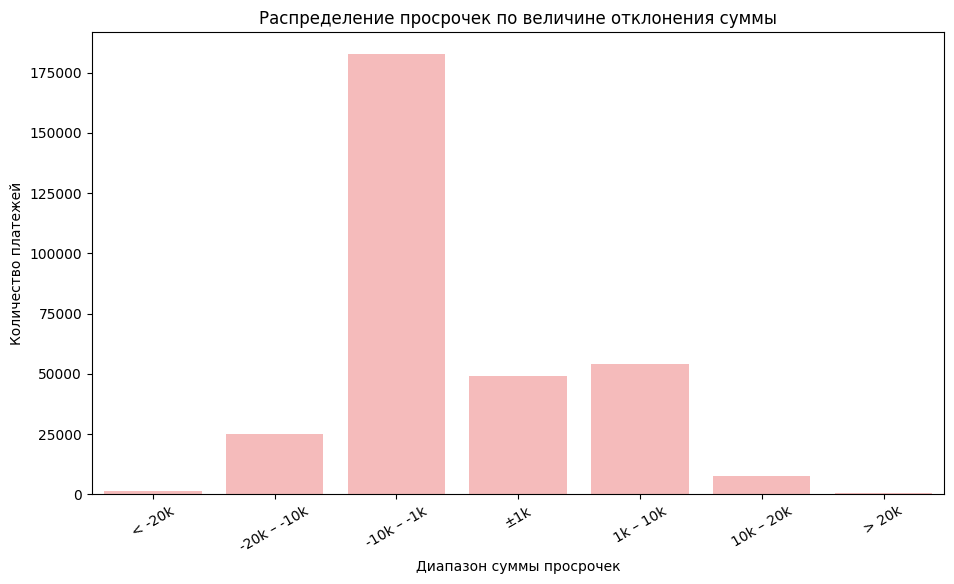

In [72]:
def amount_group_sum(a):
    if a <= -20000:
        return '< -20k'
    elif a <= -10000:
        return '-20k – -10k'
    elif a <= -1000:
        return '-10k – -1k'
    elif a < 1000:
        return '±1k'
    elif a < 10000:
        return '1k – 10k'
    elif a < 20000:
        return '10k – 20k'
    else:
        return '> 20k'

delayed['amount_group_sum'] = delayed['delay_amount'].apply(amount_group_sum)


plt.figure(figsize=(11, 6))
sns.countplot(
    data=delayed,
    x='amount_group_sum',
    order=['< -20k', '-20k – -10k', '-10k – -1k', '±1k', '1k – 10k', '10k – 20k', '> 20k'],
    color='red',
    alpha=0.3)

plt.title('Распределение просрочек по величине отклонения суммы')
plt.xlabel('Диапазон суммы просрочек')
plt.ylabel('Количество платежей')
plt.xticks(rotation=30)
plt.show()


>Ранее мы разобрались, что даже имея просрочку по дням платили меньше положенного, теперь можно увидеть сколько обычно недоплачивают, а именно 1-10 тысяч

---

## 5.5. План-факт по просрочкам

>Рассмотрим и построим график с плановымми и фактическими просроченными платежами в разрезе всех платежей и посмотрим как график делят линии среднего и медианного значения. Не забываем взять только платежи с просрочками (`delayed`)

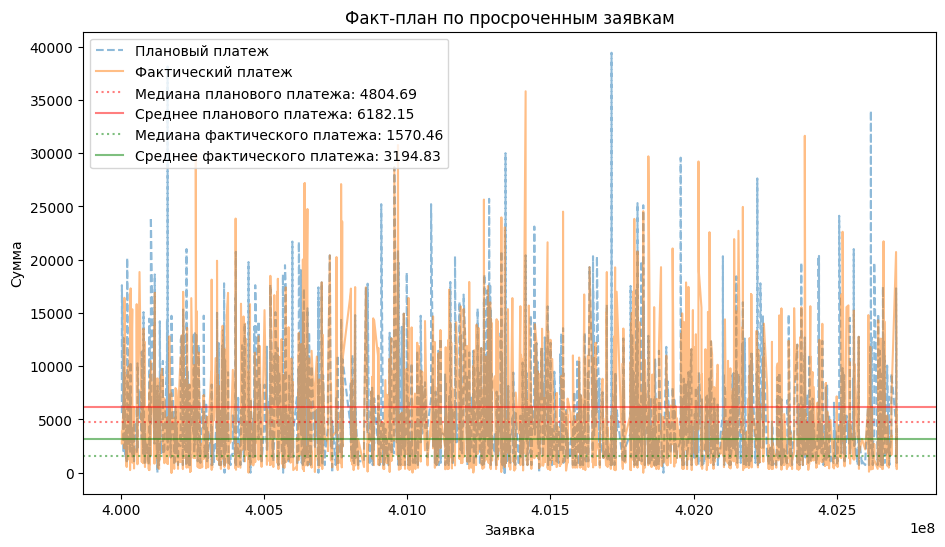

In [77]:
# Берём 10 000 первых просроченных записей, чтобы разглядеть хоть что-то
sample_data = delayed[['order_id', 'plan_sum_total', 'paid_sum']].head(10000)

median_plan = sample_data['plan_sum_total'].median()
mean_plan = sample_data['plan_sum_total'].mean()
median_paid = sample_data['paid_sum'].median()
mean_paid = sample_data['paid_sum'].mean()

# основной график
plt.figure(figsize=(11, 6))
plt.plot(sample_data['order_id'], sample_data['plan_sum_total'], label='Плановый платеж', linestyle='--', alpha=0.5)
plt.plot(sample_data['order_id'], sample_data['paid_sum'], label='Фактический платеж', alpha=0.5)

# медианы и средние
plt.axhline(median_plan, color='red', linestyle=':', label=f'Медиана планового платежа: {round(median_plan, 2)}', alpha = 0.5)
plt.axhline(mean_plan, color='red', linestyle='-', label=f'Среднее планового платежа: {round(mean_plan, 2)}', alpha = 0.5)
plt.axhline(median_paid, color='green', linestyle=':', label=f'Медиана фактического платежа: {round(median_paid, 2)}', alpha = 0.5)
plt.axhline(mean_paid, color='green', linestyle='-', label=f'Среднее фактического платежа: {round(mean_paid, 2)}', alpha = 0.5)

plt.title('Факт-план по просроченным заявкам')
plt.xlabel('Заявка')
plt.ylabel('Сумма')
plt.legend(loc='best')
plt.show()

>почти ничего нельзя разобрать, никакой тенденции по факт-плану просрочек нету, а средняя и медианы находятся в самых концентрированных областях, что, в целом, логично

---

## 5.6. Отклонения платежей при просрочках

>Для наглядности, посмотрим на отклонения платежей при просрочках 

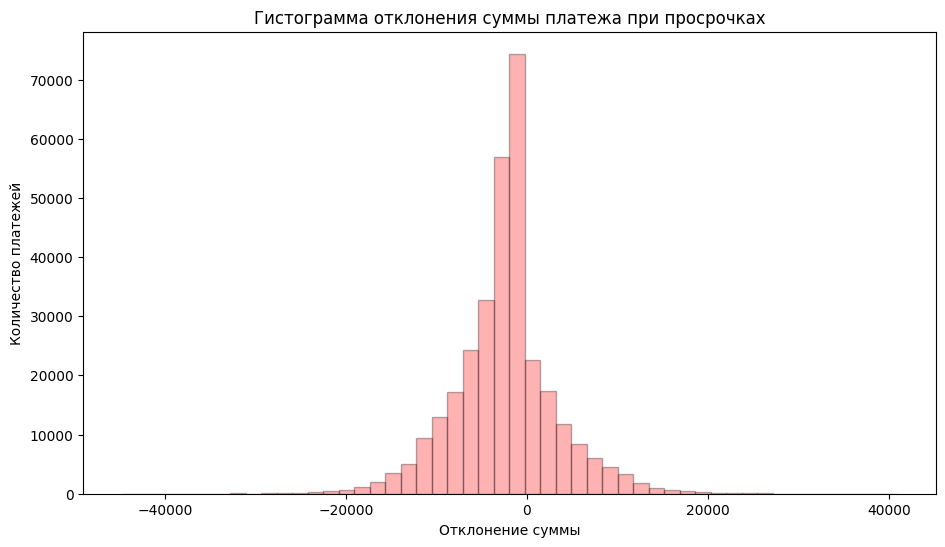

In [82]:
plt.figure(figsize=(11, 6))
delayed['delay_amount'].hist(bins=50, color='red', edgecolor='black', alpha = 0.3)

plt.title('Гистограмма отклонения суммы платежа при просрочках')
plt.xlabel('Отклонение суммы')
plt.ylabel('Количество платежей')
plt.grid(False)
plt.show()

>Не забываем, что рассматриваем только просроченные платежи, так что учитывая это и посмотрев на график, легко увидеть, что недоплат больше чем переплат, потому что левый хвост выше чем правый, в левом хвосте больше платежей

---

# 6. Динамика поведения клиентов

>Оценим динамику поведения клиентов со временем и выявим - есть ли тренд в увеличении или снижении просрочек<br><br>
>`delay_rate` - доля просроченных платежей<br>
>`total_plans` - общее количество заявок<br>
>`delay_count` - количество просроченных платежей<br>
>`avg_delay_days` - среднее количество дней просрочки<br>


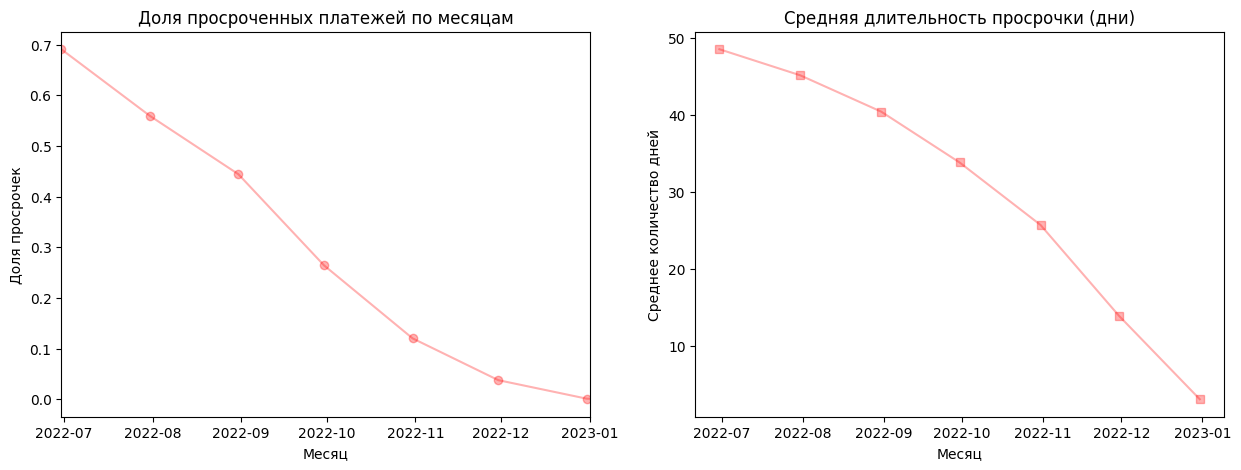

In [87]:
# агрегируем по месяцам (ME)
month_stat = plan_pay.groupby(pd.Grouper(key='plan_at', freq='ME')).agg(
    delay_rate=('is_delay', 'mean'),
    total_plans=('order_id', 'count'),
    delay_count=('is_delay', 'sum'),
    avg_delay_days=('delay_days', lambda x: x[x > 0].mean())
).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Доля просроченных платежей по месяцам
axs[0].plot(month_stat['plan_at'], month_stat['delay_rate'], marker='o', color='red', alpha=0.3)
axs[0].set_title('Доля просроченных платежей по месяцам')
axs[0].set_xlabel('Месяц')
axs[0].set_ylabel('Доля просрочек')
# чтобы не учитывать даты плановых платжей
axs[0].set_xlim([month_stat['plan_at'].min(), pd.to_datetime('2023-01')])

# Средняя длительность просрочки по месяцам
axs[1].plot(month_stat['plan_at'], month_stat['avg_delay_days'], marker='s', color='red', alpha=0.3)
axs[1].set_title('Средняя длительность просрочки (дни)')
axs[1].set_xlabel('Месяц')
axs[1].set_ylabel('Среднее количество дней')

plt.show()

>Можно увидеть, что тренд в целом положительны и к концу года доля просрочек уменьшается, то же можно сказать и про кол-во дней

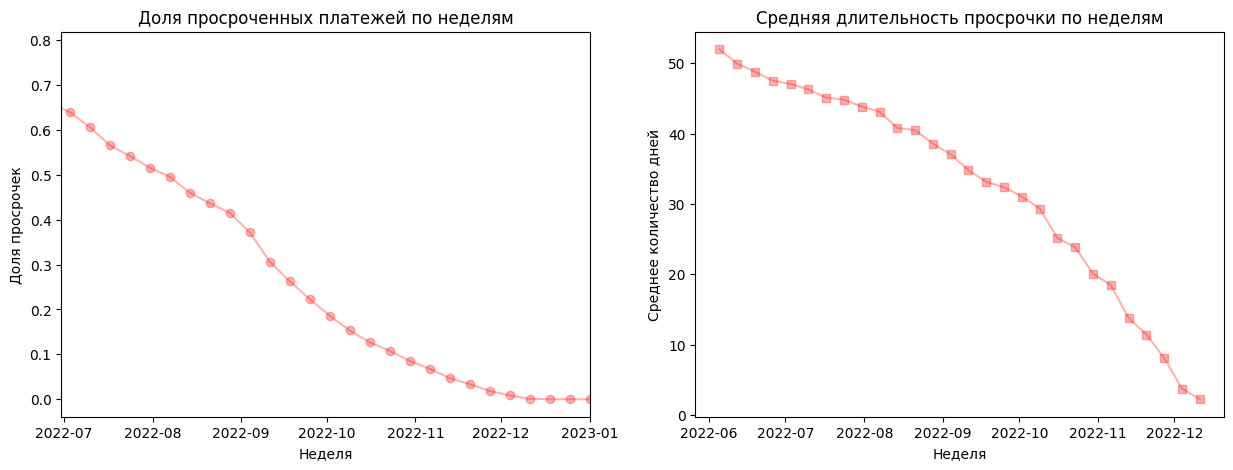

In [89]:
# Агрегируем по неделям
week_stat = plan_pay.groupby(pd.Grouper(key='plan_at', freq='W')).agg(
    delay_rate=('is_delay', 'mean'),
    total_plans=('order_id', 'count'),
    delay_count=('is_delay', 'sum'),
    avg_delay_days=('delay_days', lambda x: x[x > 0].mean())
).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(week_stat['plan_at'], week_stat['delay_rate'], marker='o', color='red', alpha=0.3)
axs[0].set_title('Доля просроченных платежей по неделям')
axs[0].set_xlabel('Неделя')
axs[0].set_ylabel('Доля просрочек')
# чтобы не учитывать даты плановых платжей
axs[0].set_xlim([month_stat['plan_at'].min(), pd.to_datetime('2023-01')])

axs[1].plot(week_stat['plan_at'], week_stat['avg_delay_days'], marker='s', color='red', alpha=0.3)
axs[1].set_title('Средняя длительность просрочки по неделям')
axs[1].set_xlabel('Неделя')
axs[1].set_ylabel('Среднее количество дней')

plt.show()

>В целом, ничего нового выцепить нельзя, график стал более плавный и подробный и можно сказать более точно, что примерно до октября среднее кол-во дней просрочек было велико, но далее начался более резвый спад 

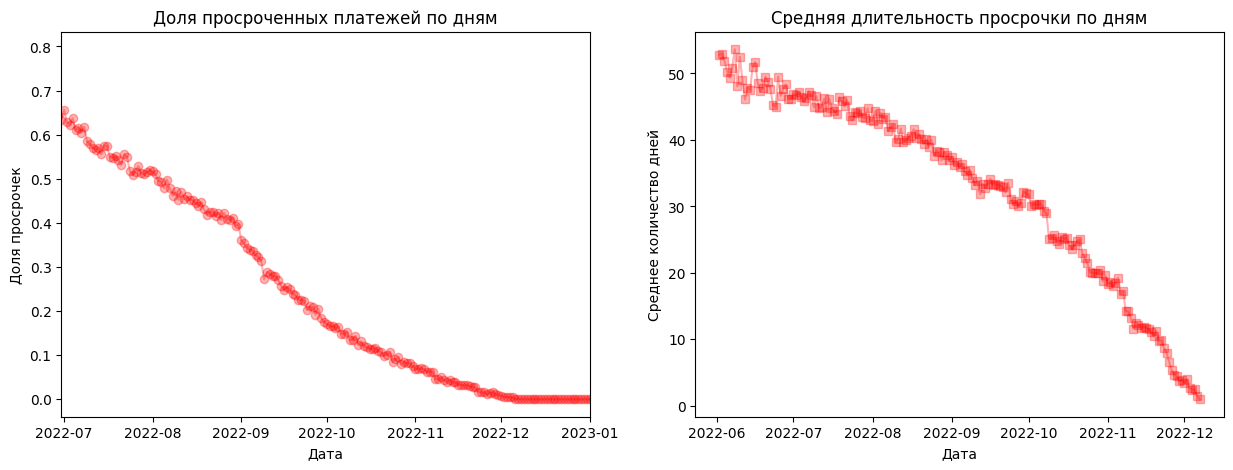

In [91]:
# Агрегируем по дням
day_stat = plan_pay.groupby(pd.Grouper(key='plan_at', freq='D')).agg(
    delay_rate=('is_delay', 'mean'),
    total_plans=('order_id', 'count'),
    delay_count=('is_delay', 'sum'),
    avg_delay_days=('delay_days', lambda x: x[x > 0].mean())
).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Доля просроченных платежей по дням
axs[0].plot(day_stat['plan_at'], day_stat['delay_rate'], marker='o', color='red', alpha=0.3)
axs[0].set_title('Доля просроченных платежей по дням')
axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Доля просрочек')
# чтобы не учитывать даты плановых платжей
axs[0].set_xlim([month_stat['plan_at'].min(), pd.to_datetime('2023-01')])

# Средняя длительность просрочки по дням
axs[1].plot(day_stat['plan_at'], day_stat['avg_delay_days'], marker='s', color='red', alpha=0.3)
axs[1].set_title('Средняя длительность просрочки по дням')
axs[1].set_xlabel('Дата')
axs[1].set_ylabel('Среднее количество дней')

plt.show()

---

## 6.1. Распредление просрочек отноистельно зявок

>Посмотрим на распределение просрочек относительно заявок. Для начала агрегируем данные <br><br>
>total_payments - кол-во платежей по заявке<br>
>total_delays - кол-во просроченых из них<br>
>avg_delay_days - средняя длительность задержки, считаем только если была задержка<br>
>max_delay - самая длинная задержка по заявке<br>

In [95]:
client_behavior = plan_pay.groupby('order_id').agg(
    total_payments=('plan_at', 'count'),
    total_delays=('is_delay', 'sum'),
    avg_delay_days=('delay_days', lambda x: x[x > 0].mean()),
    max_delay=('delay_days', 'max')
).reset_index()

>Теперь рассчитываем и добавляем долю просрочек по заявке 

In [97]:
client_behavior['delay_rate'] = client_behavior['total_delays'] / client_behavior['total_payments']
client_behavior.head()

,order_id,total_payments,total_delays,avg_delay_days,max_delay,delay_rate
0,400001732,49,19,58.842105,137.0,0.387755
1,400005838,1,0,NaN,-15.0,0.000000
2,400007915,26,2,8.500000,16.0,0.076923
3,400008952,1,1,24.000000,24.0,1.000000
4,400009027,1,1,5.000000,5.0,1.000000


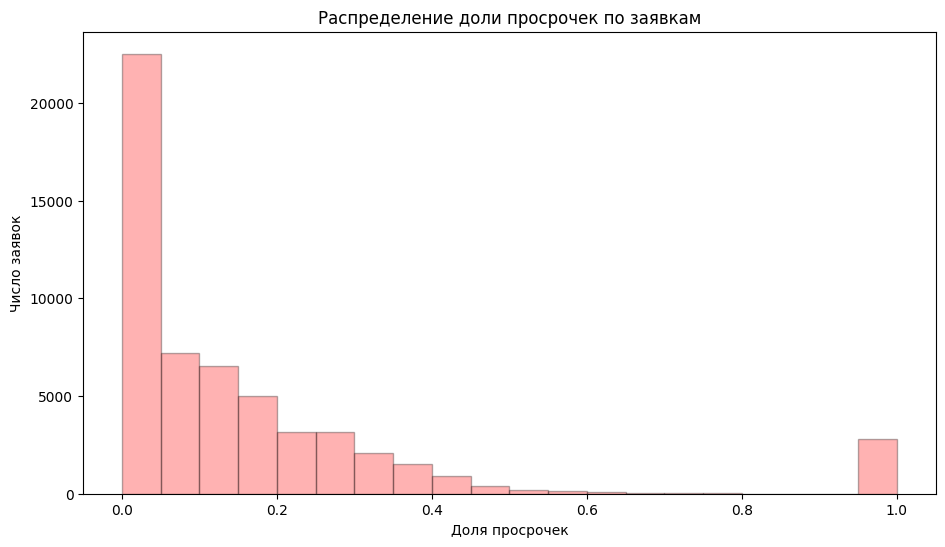

In [98]:
plt.figure(figsize=(11, 6))
plt.hist(client_behavior['delay_rate'], bins=20, color = 'red', edgecolor='black', alpha = 0.3)

plt.title('Распределение доли просрочек по заявкам')
plt.xlabel('Доля просрочек')
plt.ylabel('Число заявок')
plt.show()

>На графике видно, что большинство заявок (пик около 25-30 тыс) имеют долю просрочек менее 20%, звучит хорошо, но есть небольшой хвост распределения с высокой долей просрочек (0.8-1.0), который говорит о проблемных заявках

---

## 6.2. Частота просрочек относительно заявок

>Рассмотрим заявки по частоте просрочек

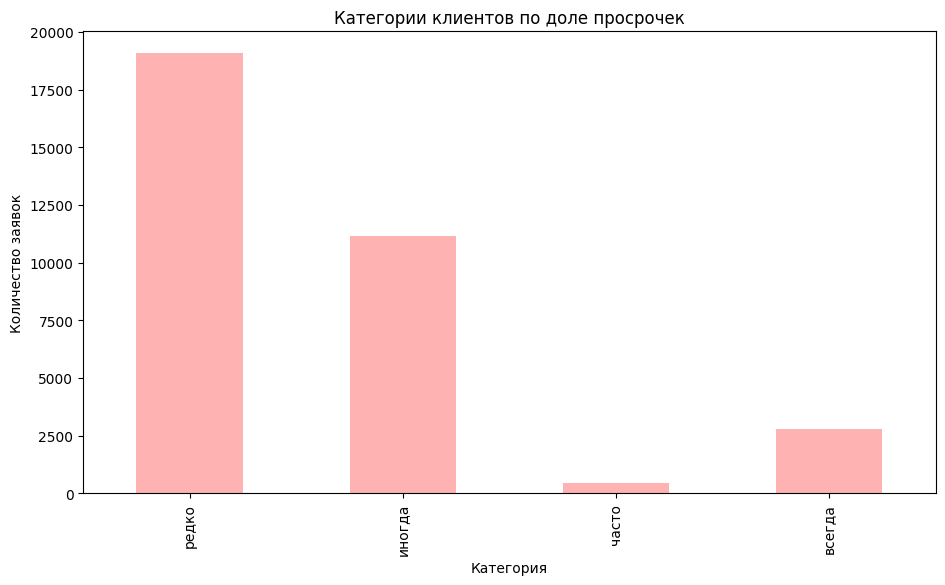

In [103]:
bins = [0, 0.2, 0.5, 0.8, 1.0]
labels = ['редко', 'иногда', 'часто', 'всегда']
client_behavior['delay_category'] = pd.cut(client_behavior['delay_rate'], bins=bins, labels=labels)

delay_dist = client_behavior['delay_category'].value_counts().sort_index()

plt.figure(figsize=(11, 6))
delay_dist.plot(kind='bar', color='red', alpha = 0.3)

plt.title('Категории клиентов по доле просрочек')
plt.xlabel('Категория')
plt.ylabel('Количество заявок')
plt.show()

>Более наглядный в рассмотрении график, на котором можно увидеть распрделение частоты просрочек по заявкам

---

# 7. Условная вероятность просрочки

> исследуем, как сумма займа `issued_sum` влияет на вероятность просрочки `delay`. Для этого будем использовать следующую формулу:<br>
> `P(delay | issued_sum > X) = sum(is_delay & issued_sum > X) / sum(issued_sum > X)`<br><br>
> тут мы ищем вероятность того, что платеж delay будет просрочен, если сумма займа > Х<br>
> для вычисления этого создаем пороги для суммы займа - разбиваем на интервалы и для каждого интервала расчитываем формулу 

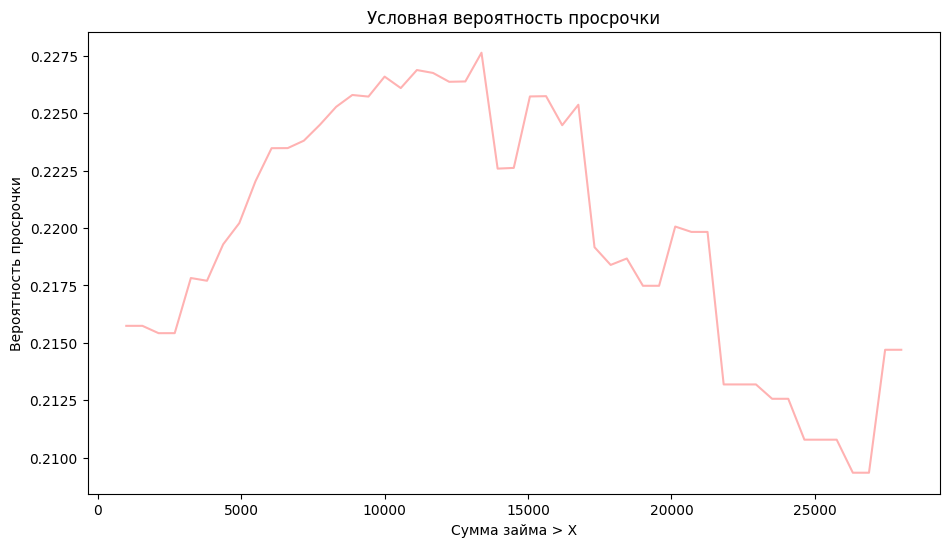

In [108]:
plan_sum = plan_pay.merge(orders[['order_id', 'issued_sum']], on='order_id', how='left')

# пороги
thresholds = np.linspace(plan_sum['issued_sum'].min(), plan_sum['issued_sum'].max(), 50)
probs = []

# вероятности
for t in thresholds:
    subset = plan_sum[plan_sum['issued_sum'] > t]
    if len(subset) > 0:
        probs.append(subset['is_delay'].mean())
    else:
        probs.append(np.nan)
        
plt.figure(figsize = (11, 6))
plt.plot(thresholds, probs, color = 'red', alpha = 0.3)

plt.xlabel('Сумма займа > X')
plt.ylabel('Вероятность просрочки')
plt.title('Условная вероятность просрочки')
plt.show()

>График показывает, что вероятность просрочки слабо, но снижается по мере увеличения суммы займа. Учитывая, что обычно большие займы рискованнее это необычно. Возможно, крупные суммы выдаются проверенным клиентам, но все равно, разница небольшая, а это говорит об относительно равномерном распределении риска

---

# 8. Вывод

> Подволя итоги анализа можно сказать, что был подробно изучен характер поведения клиентов с точки зрения просрочек. Так же внимание было уделено количественным и временным характеристикам отклонений от графика платежей, было установлено, что около 21.6% всех платежей совершаются с просрочкой и задержка составлят около 39 дней. При всем этом в большинстве случаев задержки идет с недоплатой, это видно и из статистики, и из графиков распределения

>Благодря детальнойя динамике по месяцам, неделям и дням видно, что тренд  устойчивый на снижение как доли просрочек, так и средней длительности задержек ближе к концу года. Также выявлено, что большая часть клиентов платит вовремя или с небольшим опозданием, но есть часть заявок с высокой частотой нарушений

>Кроме всего прочего дополнительно был проведён вероятностный анализ, который показал, что увеличение суммы займа не ведёт к росту вероятности просрочки, а даже, что удивительно, наоборот, видна небольшая тенденция к снижению, и мы пришли к тому, что это может говорить о том, что крупные суммы выдают более надёжным клиентам

> Таким образом, можно сделать вывод, что, в целом, поведение клиентов илюстрирует позитивную динамику, а сама система управления платежами работает стабильно, хотя небольшие рисковые группы всё ещё сохраняются и требуют внимания
